# Image Segmentation Pipeline

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from sklearn.cluster import KMeans

### Function Definitions

Function to read image from a file in RGB format

In [23]:
def readImage(file):
    image = cv2.imread(file)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [24]:
def displayImage(image, title="Image", cmap=None):
    plt.figure(figsize=(8, 8))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [25]:
def kMeansSegmentation(image, k=3):
    # Reshape the image into a 2D array of pixels
    pixels = image.reshape((-1, 3))
    
    # Apply KMeans using scikit-learn
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixels)
    centroids = kmeans.cluster_centers_
    
    # Assign each pixel to the nearest centroid
    segmentedImage = centroids[labels].reshape(image.shape).astype(np.uint8)
    
    displayImage(segmentedImage, "K-means Segmentation")
    
    # Reshape labels to match the original image dimensions
    segmentedImage = labels.reshape(image.shape[:2])
    return segmentedImage

In [26]:
def extractConnectedComponents(segmentedImage, minArea=500):
    height, width = segmentedImage.shape
    labeledImage = np.zeros_like(segmentedImage, dtype=np.int32)
    currentLabel = 1
    
    # Define a stack-based approach for connected component labeling
    def floodFill(x, y, label):
        stack = [(x, y)]
        componentPixels = []
        
        while stack:
            cx, cy = stack.pop()
            if labeledImage[cx, cy] == 0 and segmentedImage[cx, cy] == segmentedImage[x, y]:
                labeledImage[cx, cy] = label
                componentPixels.append((cx, cy))
                
                # Check neighbors
                for nx, ny in [(cx + 1, cy), (cx - 1, cy), (cx, cy + 1), (cx, cy - 1)]:
                    if 0 <= nx < height and 0 <= ny < width and labeledImage[nx, ny] == 0:
                        stack.append((nx, ny))
        
        return componentPixels
    
    for i in range(height):
        for j in range(width):
            if labeledImage[i, j] == 0:
                componentPixels = floodFill(i, j, currentLabel)
                
                # Check the area of the component
                if len(componentPixels) >= minArea:
                    currentLabel += 1
                else:
                    # If the component is too small, set its pixels back to 0
                    for x, y in componentPixels:
                        labeledImage[x, y] = 0
    
    displayImage(labeledImage, "Connected Components After Filtering", cmap="jet")
    return labeledImage, currentLabel - 1

In [27]:
def computeFeatures(labeledImage, originalImage, numLabels):
    features = []
    
    for label in range(1, numLabels + 1):
        # Extract mask for the current label
        mask = (labeledImage == label)
        component_pixels = originalImage[mask]

        # Compute area
        area = np.sum(mask)
        
        # Compute perimeter by checking border pixels
        perimeter = 0
        height, width = mask.shape
        for x in range(height):
            for y in range(width):
                if mask[x, y]:
                    # Check if this pixel has any background neighbors
                    neighbors = [
                        (x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1),
                        (x - 1, y - 1), (x - 1, y + 1), (x + 1, y - 1), (x + 1, y + 1)
                    ]
                    if any(0 <= nx < height and 0 <= ny < width and not mask[nx, ny] for nx, ny in neighbors):
                        perimeter += 1

        # Compute Hu moments manually
        moments = cv2.moments(mask.astype(np.uint8))
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Calculate mean and variance for each color channel
        mean_color = np.mean(component_pixels, axis=0)
        var_color = np.var(component_pixels, axis=0)
        
        features.append({
            "label": label,
            "area": area,
            "perimeter": perimeter,
            "hu_moments": hu_moments,
            "mean_color": mean_color,
            "var_color": var_color
        })
        
        # Display the mask of the current component
        displayImage(mask.astype(np.uint8) * 255, f"Component {label}")
    
    return features

### Pipeline

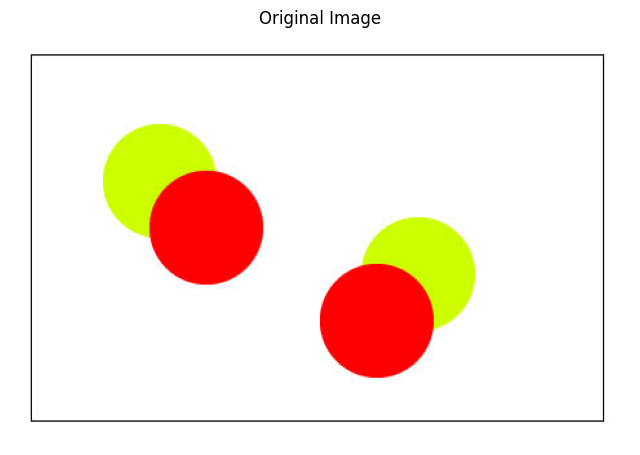

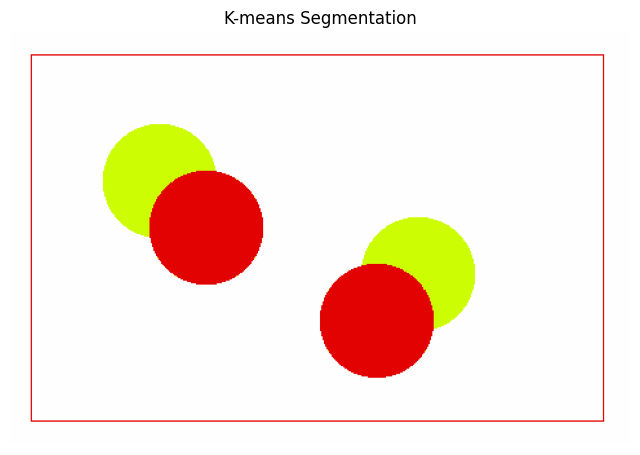

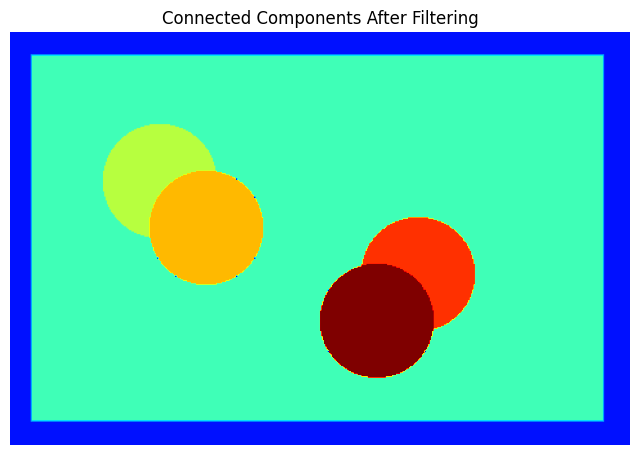

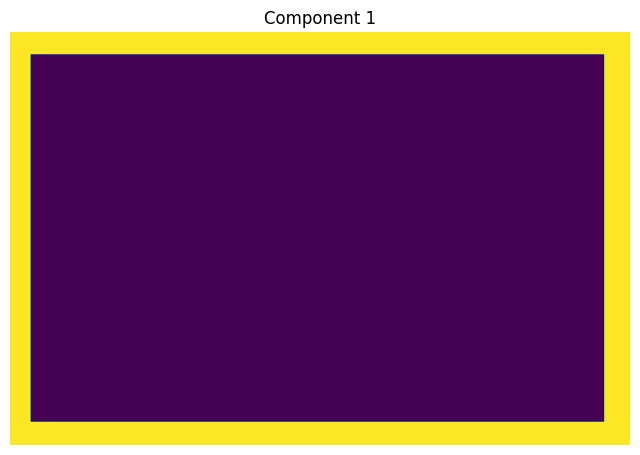

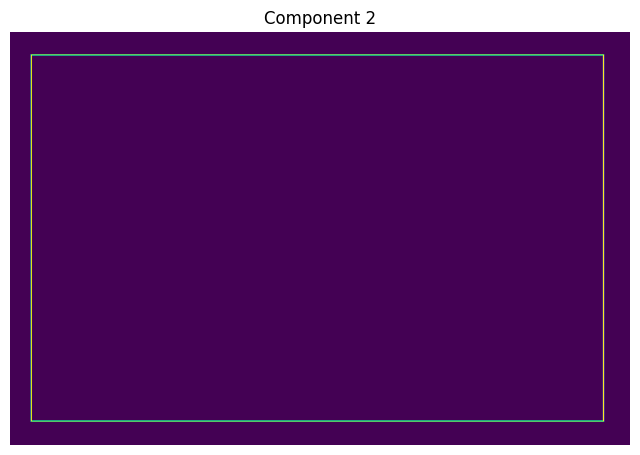

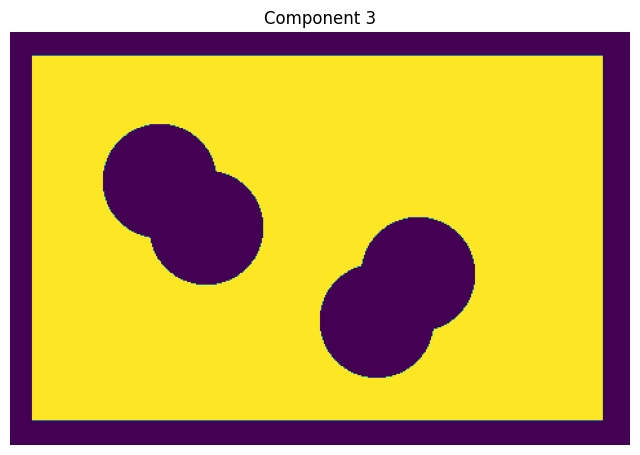

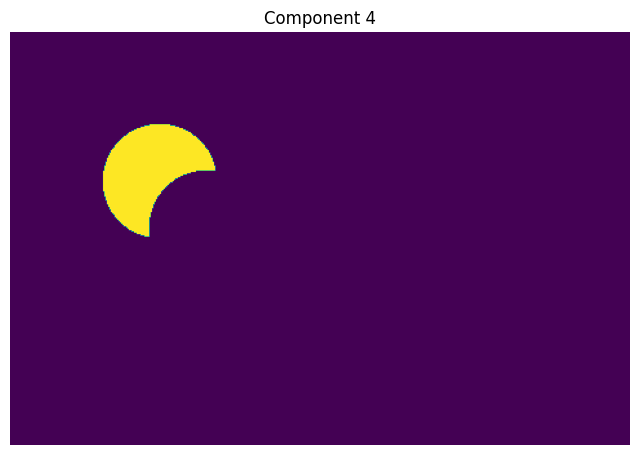

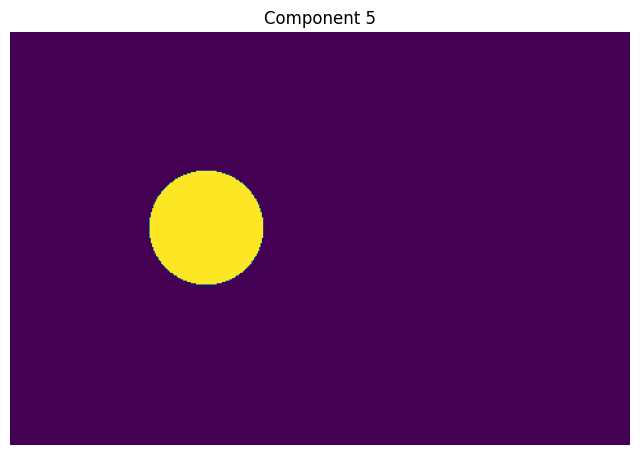

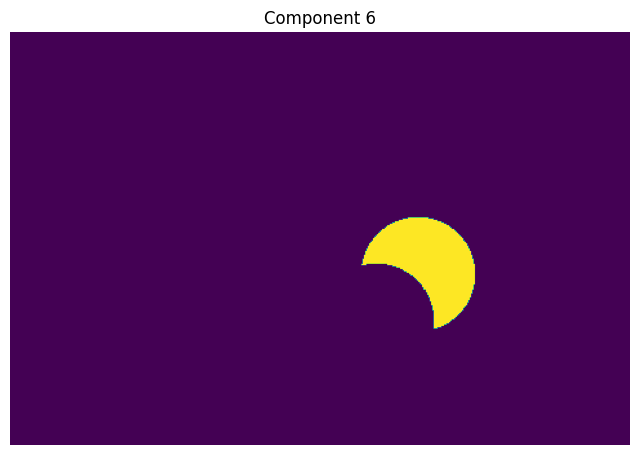

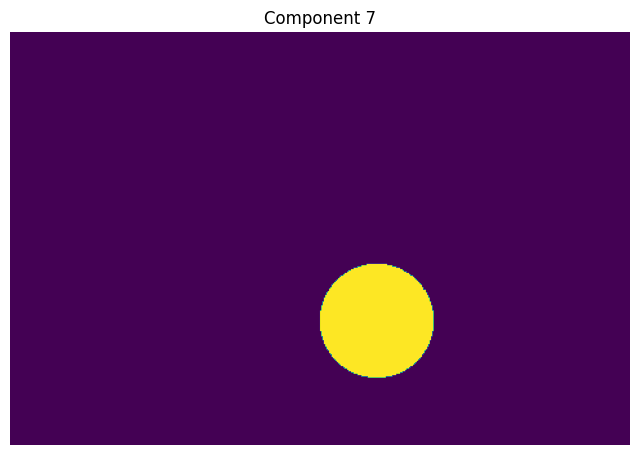

Component 1:
 - Area: 27504
 - Perimeter: 1460
 - Hu Moments: [1.76871554e+00 2.96067856e-01 1.01602311e-03 1.28240697e-02
 4.62903643e-05 6.97784792e-03 1.16384248e-18]
 - Mean Color (B, G, R): [254.87449098 254.87449098 254.87449098]
 - Variance Color (B, G, R): [0.41109449 0.41109449 0.41109449]
Component 2:
 - Area: 1452
 - Perimeter: 1452
 - Hu Moments: [30.25011478 96.78871947  0.          0.          0.          0.
  0.        ]
 - Mean Color (B, G, R): [3.90633609 3.90633609 3.90633609]
 - Variance Color (B, G, R): [4.1399874 4.1399874 4.1399874]
Component 3:
 - Area: 104069
 - Perimeter: 2436
 - Hu Moments: [2.43315513e-01 1.00455356e-02 2.19561594e-05 2.98303770e-05
 7.47176099e-10 1.79896674e-06 1.56669718e-10]
 - Mean Color (B, G, R): [254.85747917 254.81345069 254.64397659]
 - Variance Color (B, G, R): [ 1.29341236  6.63761862 16.21735557]
Component 4:
 - Area: 4242
 - Perimeter: 344
 - Hu Moments: [ 1.96578464e-01  6.23021956e-03  1.51362606e-03  1.41734074e-04
 -6.564787

In [28]:
# Load image
image_path = "testImg5.jpg"
original_image = readImage(image_path)
displayImage(original_image, "Original Image")

# Perform unsupervised segmentation using K-means from scikit-learn
segmented_image = kMeansSegmentation(original_image, k=3)

# Extract connected components with filtering for small areas
labeled_image, num_labels = extractConnectedComponents(segmented_image, minArea=500)

# Compute features for each component
features = computeFeatures(labeled_image, original_image, num_labels)

# Displaying results
for feature in features:
    print(f"Component {feature['label']}:")
    print(f" - Area: {feature['area']}")
    print(f" - Perimeter: {feature['perimeter']}")
    print(f" - Hu Moments: {feature['hu_moments']}")
    print(f" - Mean Color (B, G, R): {feature['mean_color']}")
    print(f" - Variance Color (B, G, R): {feature['var_color']}")
